In [1]:

from os import listdir
from os.path import isfile, join
import pandas as pd
import json
import os
from scipy.ndimage.measurements import label
import numpy as np
import matplotlib.pyplot as plt


def THD_Connected_components(
        THD_path = 'C:/Users/Ian Joyce/Desktop/dashboard_projects/xview_viz/data/segmentations/Euclidean (L2)_no_overlap_18_8.csv_2018.07.20 12.48',
        Chipped_data_path = 'C:/Users/Ian Joyce/Desktop/code/TDA',
        Chipped_data_name = 'Locations.csv',
        prefix = 'no_overlap_18_8_EU',
        chipsize = 8,
        image_dimensions = [366,386]):

    '''
    This function will import the THD and find the number of connected components in a 2d array
    
    '''
    
    #find the coordinates for the chipped data
    os.chdir(Chipped_data_path)
    local = pd.read_csv(Chipped_data_name)
    
    #store coordinates 
    local = np.array(local)
    
    #find the THD file names and store them in a list    
    os.chdir(str(THD_path))
    onlyfiles = [f for f in listdir(THD_path) if isfile(join(THD_path, f)) and prefix in f ]
    
    # verify data was imported
    print('Data Imported')
    
    
    # create a dictionary to store the nodes 
    temp_dict = {}
    
    # import the data from the THD
    for ii in range(0,len(onlyfiles)):
        #print(onlyfiles[ii])
        #print(ii)
        # Reading the json as a dict
        with open(onlyfiles[ii]) as json_data:
            data = json.load(json_data)
    
        roads = data["nodeRows"]
        road = []
        #print('1')
        for i in roads:
            for j in range(0,len(roads[i])):
                road.append(roads[i][j])
        
        # remove duplicates
        temp_dict[ii] = list(set(road))
        
    
    # sort the data in the THD dict
    for i in temp_dict.keys():
        temp_dict[i].sort()
         
    
    THD_dict = {}
    
    
    for ii in temp_dict.keys():
        
        x = temp_dict.keys()[ii]
        
        l = np.zeros((len(temp_dict[ii]),2)) # create a list to store the coordinates
        for i in range(0,len(temp_dict[ii])): # pull the coodinates from local (y,x) 
            l[i] = (local[temp_dict[ii][i],3],local[temp_dict[ii][i],2])
        
        # resize the coodinates 
        l = l/chipsize   
        
        # create an empty array to store boolean values: 1 if a chip occupies the coordinate
        array = np.zeros(image_dimensions)
        
        # assign the values
        for i in range(0,len(l)):
            y,x = l[i]
            array[int(x),int(y)] = 1
    
        # determine if neighbors exist using scipy.ndimage.measurements import label
        # https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html
        structure = np.ones((3, 3), dtype=np.int)
        
        
        labeled_array, ncomponents = label(array, structure)
    
        THD_dict[ii] = { 'array' : array,
                                'labeled' : labeled_array, 
                                'ncomponents': ncomponents,
                                'index' : temp_dict[ii],
                                'coordinates' : l*chipsize,
                                'data_set': onlyfiles[ii]
                                #persistence
                                }    
        # array stores the binary value, whether or not a chip is at that index
        # labeled array stores the chip cluster with an assigned int value 
    return THD_dict

THD_dict = THD_Connected_components()



########################################
########################################



Data Imported


NameError: name 'dict_index' is not defined

In [ ]:


def CC_viz(THD_node = 'GROUPDATA_no_overlap_18_8_EU.1.1.1.2.json',
           number_connected_components = 1000, # assign a threasholds for the number of components that are connected 
           number_connected_components_2 = 100,
           THD = THD_dict ):

    
    # pull the dictionary keys    
    for i in range(0,len(list(THD_dict.keys()))):
        if THD_dict[i]['data_set'] == THD_node:
            dict_key = i
            #print(i)
    
    
    
    # find the clusters within the specified node that exceed the number of connected components of the first threshold     
    mapp = np.zeros(THD_dict[dict_key]['labeled'].shape)
    
    for i in range(1,THD_dict[dict_key]['ncomponents']):
        if len(THD_dict[dict_key]['labeled'][THD_dict[dict_key ]['labeled'] == i]) >=number_connected_components: 
           
            x = np.where( THD_dict[dict_key]['labeled'] == i )
            for j in range(0,len(x[0])):
                mapp[x[0][j]][x[1][j]] = 1


    # find the clusters within the specified node that exceed the number of connected components of the second threshold     
    mapp_2 = np.zeros(THD_dict[dict_key]['labeled'].shape)
    
    for i in range(1,THD_dict[dict_key]['ncomponents']):
        if len(THD_dict[dict_key]['labeled'][THD_dict[dict_key ]['labeled'] == i]) >=number_connected_components_2: 
           
            x = np.where( THD_dict[dict_key]['labeled'] == i )
            for j in range(0,len(x[0])):
                mapp_2[x[0][j]][ x[1][j]] = 1
                   
                
                
    # plot the maps 
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20,10))
    axes[0].imshow(mapp)
    axes[0].axis('off') 
    axes[1].imshow(mapp_2)
    axes[1].axis('off') 
    #axes[1].imshow(THD_dict[dict_key]['array'])
    axes[1].set_title(str(dict_key) + ' :  ' + str(THD_dict[dict_key]['data_set'])).set_size(20)
    axes[2].imshow(THD_dict[dict_key]['array'])
    axes[2].axis('off') 


CC_viz(THD = THD_dict)





In [2]:



def THD_Traverse(node =  'GROUPDATA_no_overlap_18_8_EU.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.2.json',
                 prefix = 'GROUPDATA_no_overlap_18_8_EU.',
                 THD_dict = THD_dict,
                 steps = 5,
                 number_connected_components = 1000,
                 up = True,
                 parent = True):
    
    # clean the node's name so that the original position only contains the tree's coordinates
    prefix_len = len('GROUPDATA_no_overlap_18_8_EU.')
    original_position = node[prefix_len:len(node)-5]    # - 5 will remove the .json
    
    # original_position = '1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.2'
    
    # traverse up the tree
    if up == True:
        traverse_up = {}

    
        len(original_position)
        position = original_position
        for i in range(0,steps):
            position = position[0:len(position)-2]
            x = prefix + position + '.json'
            traverse_up[i] = { 'image': i,
                              'node_name': x,
                              'length': len(THD_dict[i]['coordinates'])} 
            # the number of coordiates will be used to retrieve singletons
        return traverse_up
    # traverse down the tree
    else:
        traverse_down = {}
        for i in THD_dict.keys():
            if THD_dict[i]['data_set'][0:prefix_len + len(original_position)] == node[0:len(node)-5]:
                dict_key = i
                #print(i,THD_dict[i]['data_set'])
                #l.append([i,THD_dict[i]['data_set']])
                traverse_down[i] = {'image': i,
                             'node_name': THD_dict[i]['data_set'],
                             #'coordinates': THD_dict[i]['coordinates'],
                             'length': len(THD_dict[i]['coordinates']) }
                
        return traverse_down 
    


THD_Traverse(steps = 7, THD_dict = THD_dict, up = False)


{20: {'image': 20,
  'length': 2083,
  'node_name': 'GROUPDATA_no_overlap_18_8_EU.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.2.1.1.1.1.1.1.1.json'},
 21: {'image': 21,
  'length': 1162,
  'node_name': 'GROUPDATA_no_overlap_18_8_EU.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.2.1.1.1.1.1.1.2.json'},
 22: {'image': 22,
  'length': 340,
  'node_name': 'GROUPDATA_no_overlap_18_8_EU.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.2.1.1.1.1.1.1.3.json'},
 23: {'image': 23,
  'length': 4746,
  'node_name': 'GROUPDATA_no_overlap_18_8_EU.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.2.1.1.1.1.1.1.json'},
 24: {'image': 24,
  'length': 5564,
  'node_name': 'GROUPDATA_no_overlap_18_8_EU.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.2.1.1.1.1.1.json'},
 25: {'image': 25,
  'length': 1340,
  'node_name': 'GROUPDATA_no_overlap_18_8_EU.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.2.1.1.1.1.2.json'},
 26: {'image': 26,
  'length': 7963,
  'node_name': 'GROUPDATA_no_overlap_18_8_EU.1.1.1.1.1.1.1.1.1

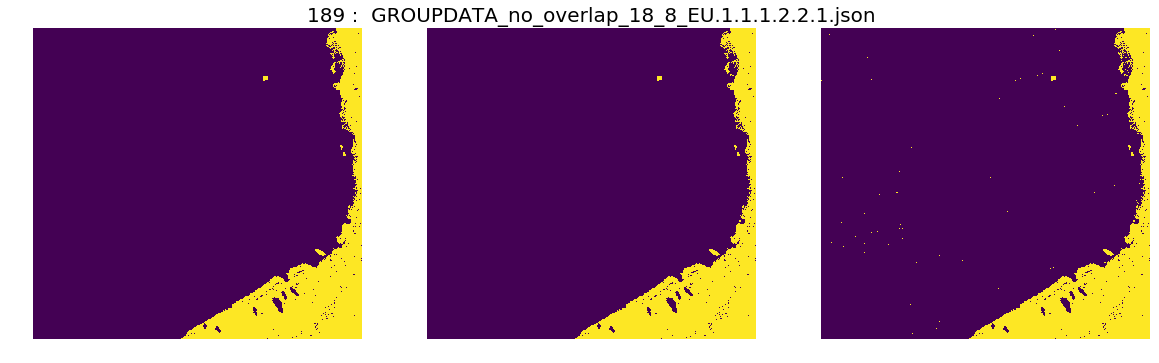

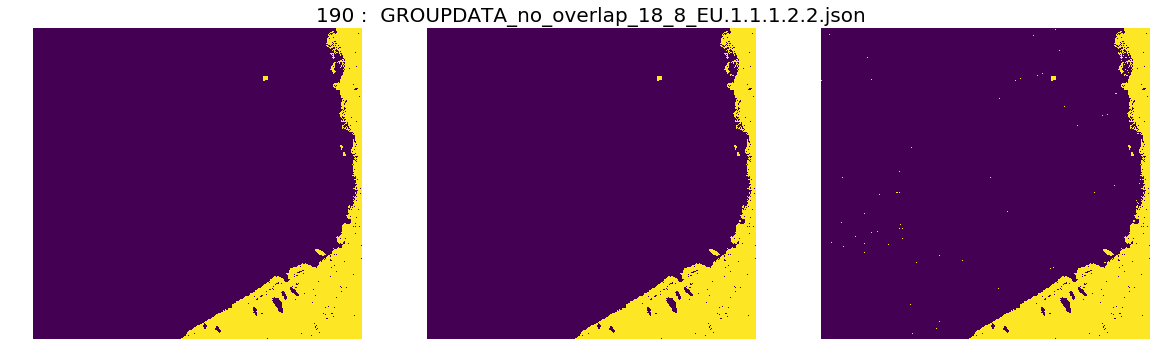

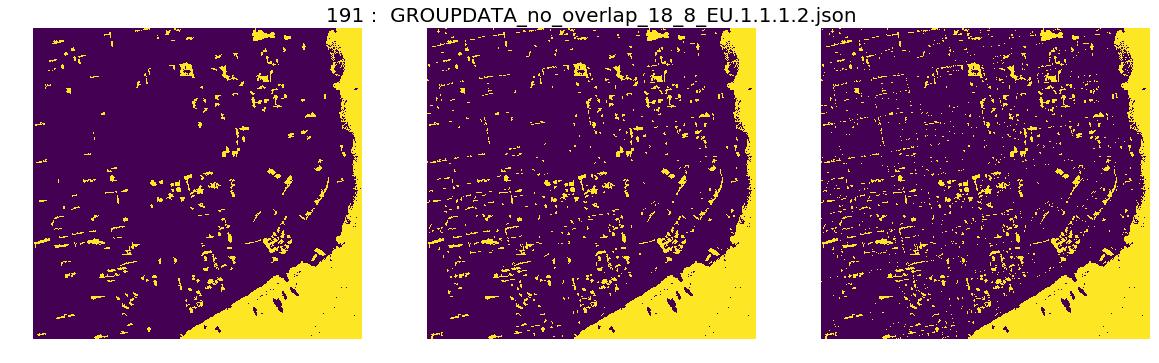

In [3]:

traverse = THD_Traverse(node = 'GROUPDATA_no_overlap_18_8_EU.1.1.1.2.2.1.1.json', steps = 3 )

for i in traverse.keys():
    #print i
    CC_viz(traverse[i]['node_name'], 10,3)

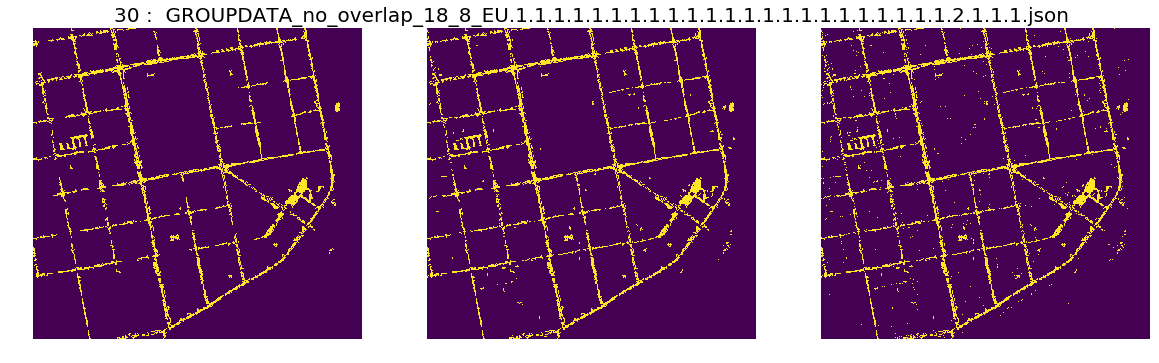

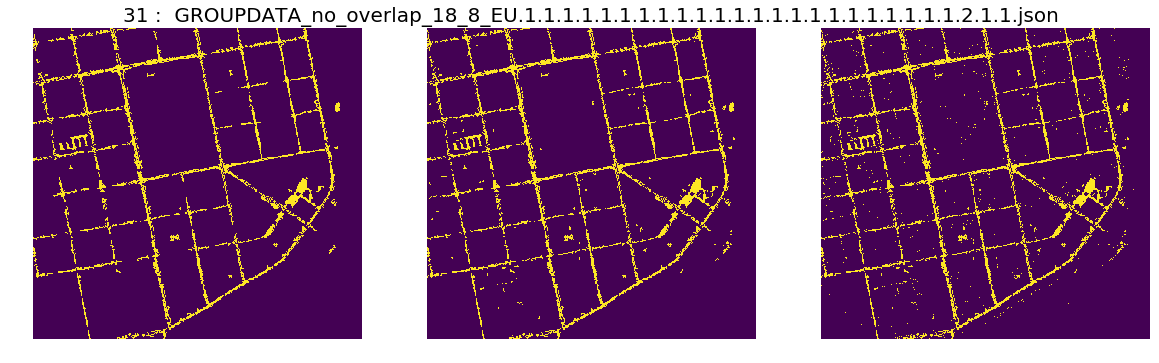

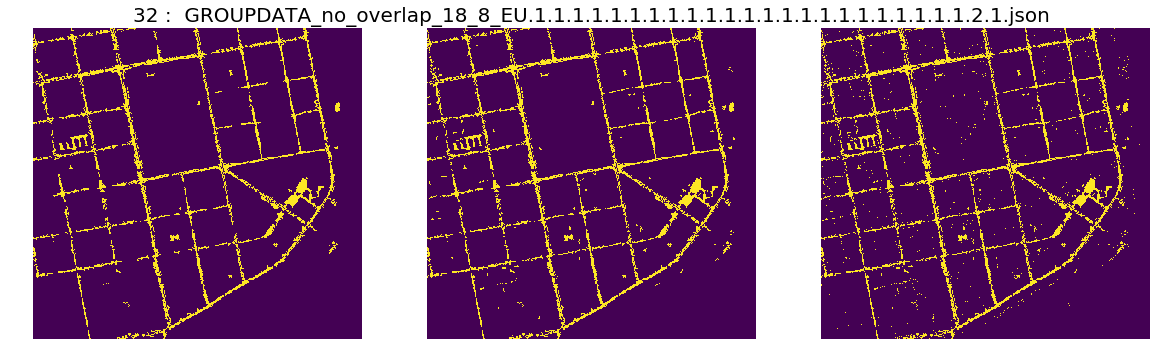

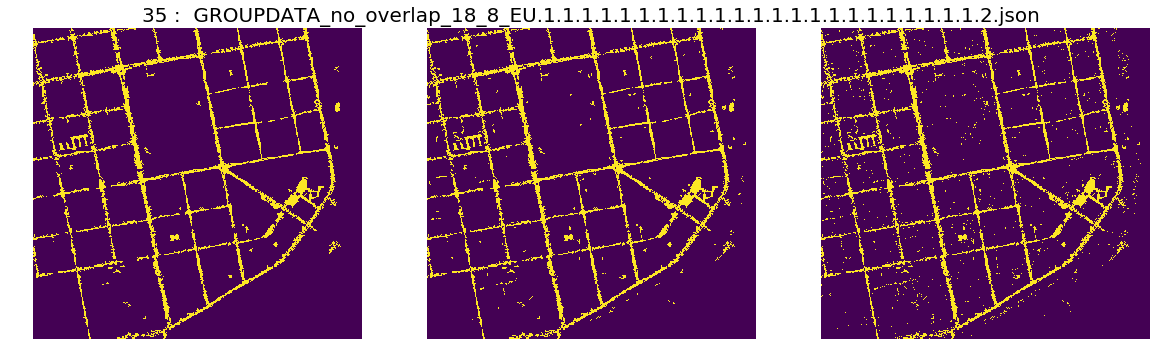

In [4]:
traverse = THD_Traverse(node = 'GROUPDATA_no_overlap_18_8_EU.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.2.1.1.1.1.json', steps = 4 )  


for i in traverse.keys():
    #print i
    CC_viz(traverse[i]['node_name'], 10,3)

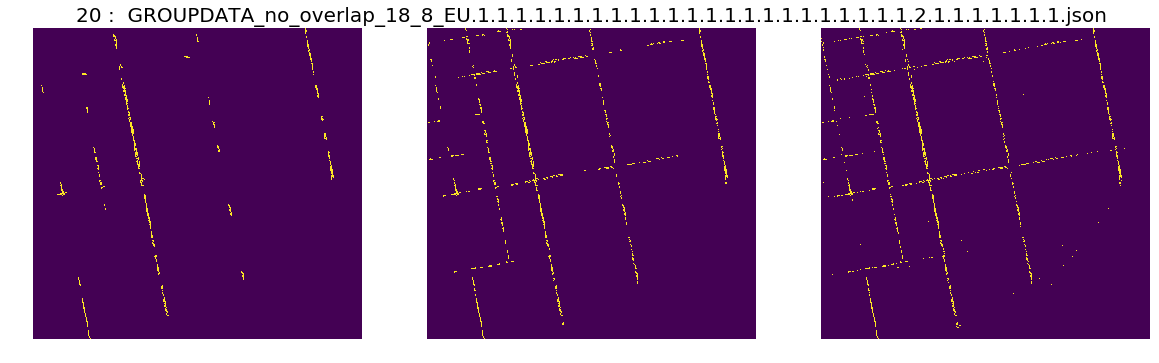

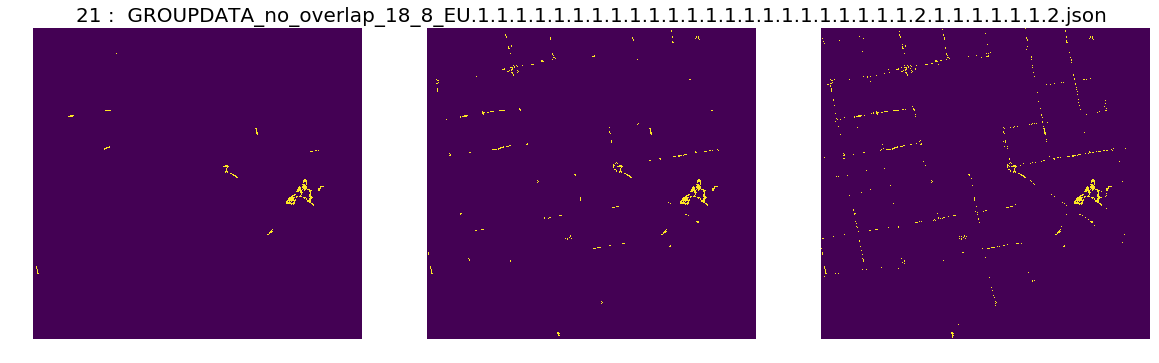

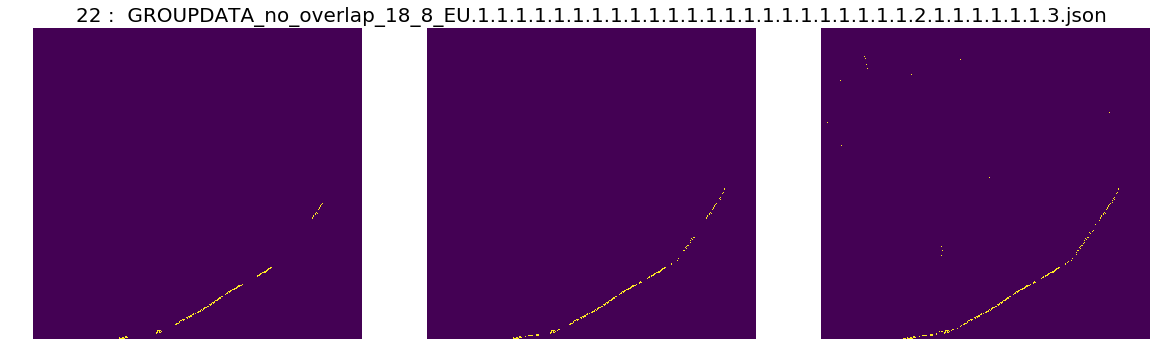

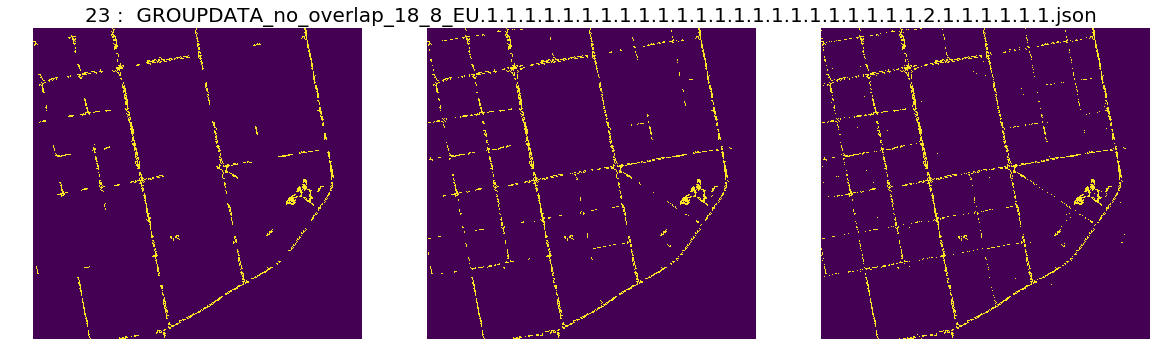

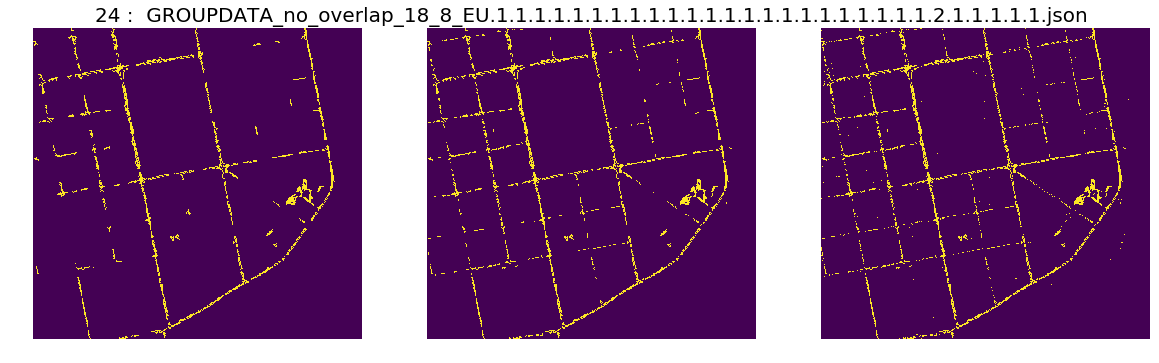

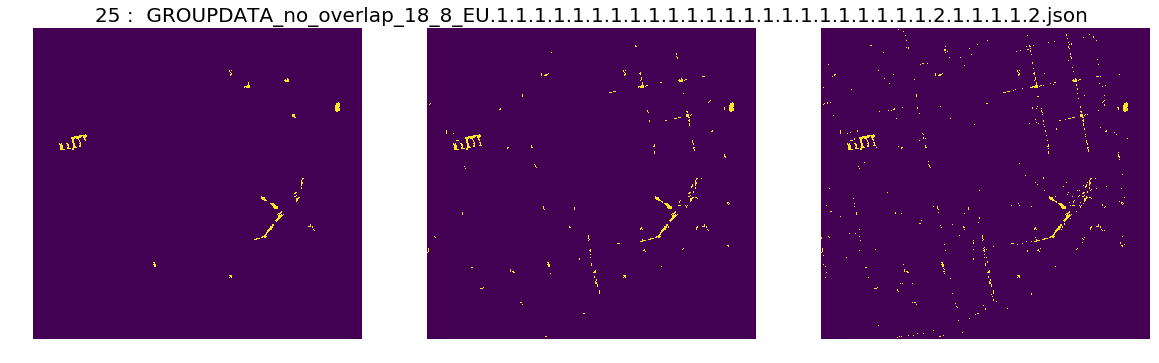

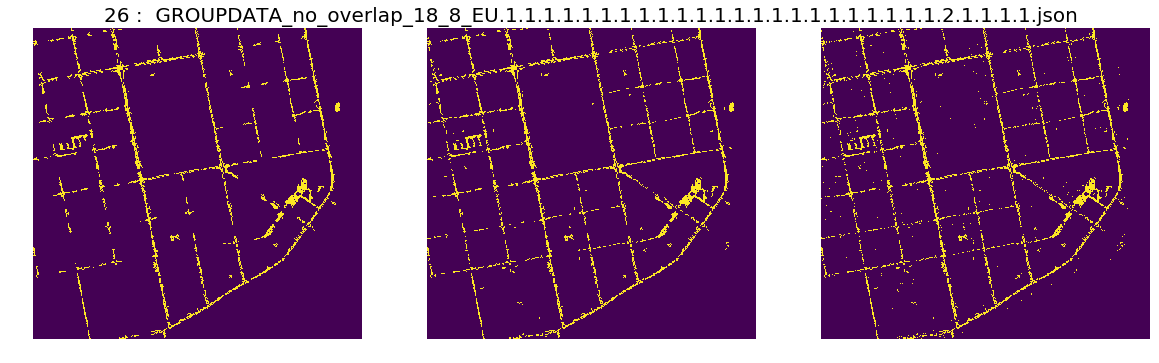

In [7]:
traverse = THD_Traverse(node = 'GROUPDATA_no_overlap_18_8_EU.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.1.2.1.1.1.1.json',
                        steps = 7, THD_dict = THD_dict, up = False)

for i in traverse.keys():
    #print i
    CC_viz(traverse[i]['node_name'], 10,3)
